In [1]:
import json
import networkx as nx
from networkx.readwrite import json_graph
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
# Ruta al archivo
path = r"C:\Users\glova\Downloads\MC3_release_viz\MC3_release\MC3_graph_corregido.json"

# Cargar el JSON
with open(path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Convertir a grafo
G = json_graph.node_link_graph(data, directed=True)

 ## Extraer eventos con timestamp

In [5]:
event_nodes = [
    (n, attr) for n, attr in G.nodes(data=True)
    if attr.get('type') == 'Event' and 'timestamp' in attr and attr['timestamp']
]

df_events = pd.DataFrame([
    {
        "id": n,
        "type": attr.get("sub_type"),
        "timestamp": pd.to_datetime(attr.get("timestamp")),
        "label": attr.get("label"),
        "findings": attr.get("findings", ""),
        "content": attr.get("content", "")
    }
    for n, attr in event_nodes
])

df_events = df_events.sort_values(by="timestamp")

In [6]:
# Agrupar por fecha
event_ids_by_date = df_events.groupby(df_events["timestamp"].dt.date)["id"].apply(list)

# Crear subgrafos por fecha
subgraphs_by_date = {}
for date, event_ids in event_ids_by_date.items():
    nodes = set(event_ids)
    for e in event_ids:
        nodes.update(G.predecessors(e))
        nodes.update(G.successors(e))
    subgraph = G.subgraph(nodes).copy()
    subgraphs_by_date[date] = subgraph

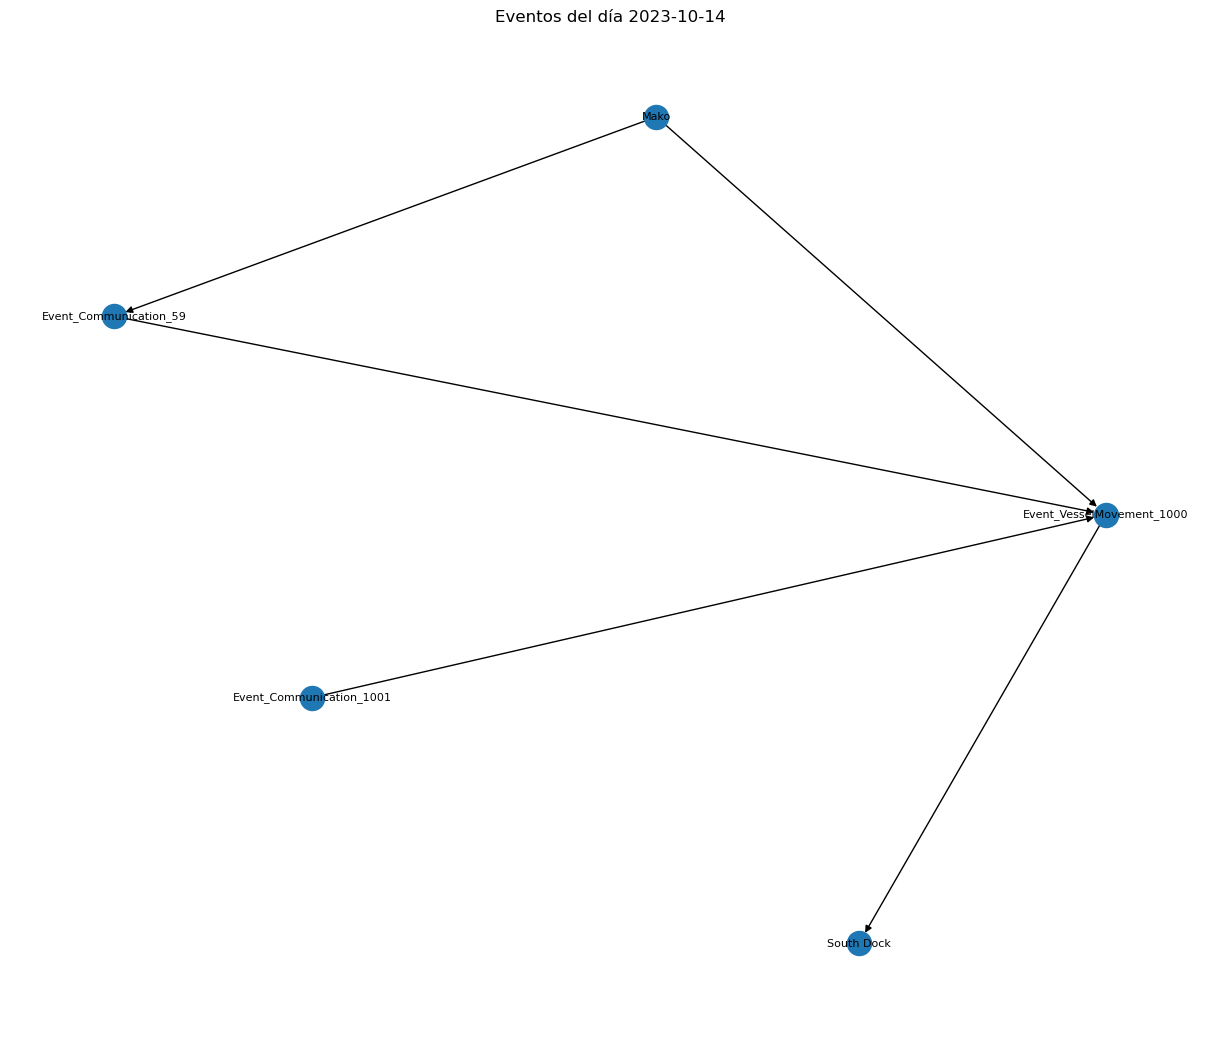

In [7]:
# Elegimos una fecha
sample_date = list(subgraphs_by_date.keys())[0]
subg = subgraphs_by_date[sample_date]

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subg, seed=42)
nx.draw(subg, pos, with_labels=True, node_size=300, font_size=8)
plt.title(f"Eventos del día {sample_date}")
plt.show()

#### Fechas de los eventos

In [8]:
# Asegúrate de haber cargado el grafo como G
from datetime import datetime
import pandas as pd

# Extraer nodos de tipo Event que tengan timestamp
event_nodes = [
    attr for _, attr in G.nodes(data=True)
    if attr.get("type") == "Event" and attr.get("timestamp")
]

# Crear DataFrame de eventos
df_eventos = pd.DataFrame([
    {
        "timestamp": pd.to_datetime(e["timestamp"])
    }
    for e in event_nodes
])

# Mostrar todas las fechas únicas
fechas_unicas = df_eventos["timestamp"].dt.date.unique()
sorted(fechas_unicas)


[datetime.date(2023, 10, 14),
 datetime.date(2040, 10, 1),
 datetime.date(2040, 10, 2),
 datetime.date(2040, 10, 3),
 datetime.date(2040, 10, 4),
 datetime.date(2040, 10, 5),
 datetime.date(2040, 10, 6),
 datetime.date(2040, 10, 7),
 datetime.date(2040, 10, 8),
 datetime.date(2040, 10, 9),
 datetime.date(2040, 10, 10),
 datetime.date(2040, 10, 11),
 datetime.date(2040, 10, 12),
 datetime.date(2040, 10, 13),
 datetime.date(2040, 10, 14),
 datetime.date(2040, 10, 15)]

## Tabla

In [9]:
entity_links = []

for node in G.nodes:
    node_data = G.nodes[node]
    
    if node_data.get("type") in ["Event", "Relationship"]:
        in_edges = list(G.in_edges(node))
        out_edges = list(G.out_edges(node))
        
        source_entities = [src for src, _ in in_edges if G.nodes[src].get("type") == "Entity"]
        target_entities = [tgt for _, tgt in out_edges if G.nodes[tgt].get("type") == "Entity"]

        for source in source_entities:
            for target in target_entities:
                entry = {
                    "source": G.nodes[source]["label"],
                    "target": G.nodes[target]["label"],
                    "via": node_data["label"],
                    "via_type": node_data["type"],
                    "sub_type": node_data.get("sub_type")
                }

                # Si es una comunicación, agregamos el texto y la fecha
                if node_data["type"] == "Event" and node_data.get("sub_type") == "Communication":
                    entry["timestamp"] = node_data.get("timestamp")
                    entry["content"] = node_data.get("content")
                else:
                    entry["timestamp"] = None
                    entry["content"] = None

                entity_links.append(entry)


In [10]:
df_entity_links = pd.DataFrame(entity_links)
df_entity_links.sort_values(by="timestamp", inplace=True)  # Opcional
df_entity_links.head(10)


,source,target,via,via_type,sub_type,timestamp,content
49,The Lookout,The Intern,Communication,Event,Communication,2040-10-01 08:09:00,"Hey The Intern, it's The Lookout! Just spotted..."
50,The Intern,The Lookout,Communication,Event,Communication,2040-10-01 08:10:00,"Hey The Lookout, The Intern here! I'd absolute..."
51,Kelly,Sam,Communication,Event,Communication,2040-10-01 08:13:00,"Sam, it's Kelly! Let's meet at Sunrise Point a..."
52,The Intern,Mrs. Money,Communication,Event,Communication,2040-10-01 08:16:00,"Mrs. Money, it's The Intern. Just checking in ..."
53,Mrs. Money,Boss,Communication,Event,Communication,2040-10-01 08:19:00,"Boss, it's Mrs. Money. I've reviewed our opera..."
54,Boss,Mrs. Money,Communication,Event,Communication,2040-10-01 08:21:00,"Mrs. Money, this is Boss. I'm available tomorr..."
55,Mrs. Money,Boss,Communication,Event,Communication,2040-10-01 08:24:00,"Boss, Mrs. Money here. I'll bring the updated ..."
56,Boss,The Middleman,Communication,Event,Communication,2040-10-01 08:26:00,"Middleman, this is Boss. I'd like to move our ..."
57,The Middleman,Boss,Communication,Event,Communication,2040-10-01 08:29:00,"Boss, this is The Middleman. I can meet earlie..."
58,Boss,The Middleman,Communication,Event,Communication,2040-10-01 08:32:00,"Middleman, this is Boss. Let's meet tomorrow a..."


In [14]:
# Ruta donde guardar el archivo
ruta_salida = r"C:\Users\glova\OneDrive\Documentos\Visualización\relaciones_entidades_jsoncorregido.xlsx"

# Guardar como Excel
df_entity_links.to_excel(ruta_salida, index=False)

print("✅ Archivo guardado correctamente en:")
print(ruta_salida)

✅ Archivo guardado correctamente en:
C:\Users\glova\OneDrive\Documentos\Visualización\relaciones_entidades_jsoncorregido.xlsx


## Nadia Conti

In [15]:
df = df_entity_links

# Filtrar todas las filas donde Nadia es source o target
nadia_df = df[(df['source'] == 'Nadia Conti') | (df['target'] == 'Nadia Conti')]

# Ordenar por fecha si está disponible
nadia_df = nadia_df.sort_values(by='timestamp')

# Ver las primeras filas
nadia_df


,source,target,via,via_type,sub_type,timestamp,content
233,Haacklee Harbor,Nadia Conti,Communication,Event,Communication,2040-10-05 09:44:00,Haacklee Harbor to Nadia Conti. Following your...
234,Nadia Conti,Haacklee Harbor,Communication,Event,Communication,2040-10-05 09:45:00,"Haacklee Harbor, this is Nadia Conti. I need t..."
236,Oceanus City Council,Nadia Conti,Communication,Event,Communication,2040-10-05 09:48:00,"Ms. Conti, this is Oceanus City Council. We ne..."
237,Nadia Conti,Oceanus City Council,Communication,Event,Communication,2040-10-05 09:49:00,This is Nadia Conti. My cancellation was due t...
348,Sailor Shifts Team,Nadia Conti,Communication,Event,Communication,2040-10-07 11:57:00,"Hi Nadia, this is the Sailor Shifts Team. Rece..."
349,Davis,Nadia Conti,Communication,Event,Communication,2040-10-07 12:00:00,"Davis, Nadia here. Let's meet at 7PM at the ma..."
352,Elise,Nadia Conti,Communication,Event,Communication,2040-10-08 08:15:00,"Nadia, Elise here. Meeting at Nemo Reef 0500 t..."
353,Nadia Conti,Liam Thorne,Communication,Event,Communication,2040-10-08 08:18:00,"Liam, Nadia here. Need your services urgently...."
356,Liam Thorne,Nadia Conti,Communication,Event,Communication,2040-10-08 08:24:00,"Nadia, Liam here. Meeting confirmed for tomorr..."
357,Nadia Conti,Neptune,Communication,Event,Communication,2040-10-08 08:25:00,"Neptune, this is Nadia. Need clarity on 'under..."


In [12]:
# Lista de palabras clave sospechosas
keywords = ["reef", "equipment", "sampling", "permit", "illegal", "violation", "drilling", "extraction", "mining", "unauthorized"]

# Crear una columna para marcar si hay alguna palabra clave en el mensaje
nadia_df['sospechoso'] = nadia_df['content'].fillna('').apply(
    lambda x: any(k.lower() in x.lower() for k in keywords)
)

# Mostrar los mensajes sospechosos
mensajes_sospechosos = nadia_df[nadia_df['sospechoso']]
mensajes_sospechosos[['timestamp', 'source', 'target', 'content']]


,timestamp,source,target,content
233,2040-10-05 09:44:00,Haacklee Harbor,Nadia Conti,Haacklee Harbor to Nadia Conti. Following your...
234,2040-10-05 09:45:00,Nadia Conti,Haacklee Harbor,"Haacklee Harbor, this is Nadia Conti. I need t..."
236,2040-10-05 09:48:00,Oceanus City Council,Nadia Conti,"Ms. Conti, this is Oceanus City Council. We ne..."
237,2040-10-05 09:49:00,Nadia Conti,Oceanus City Council,This is Nadia Conti. My cancellation was due t...
348,2040-10-07 11:57:00,Sailor Shifts Team,Nadia Conti,"Hi Nadia, this is the Sailor Shifts Team. Rece..."
349,2040-10-07 12:00:00,Davis,Nadia Conti,"Davis, Nadia here. Let's meet at 7PM at the ma..."
352,2040-10-08 08:15:00,Elise,Nadia Conti,"Nadia, Elise here. Meeting at Nemo Reef 0500 t..."
353,2040-10-08 08:18:00,Nadia Conti,Liam Thorne,"Liam, Nadia here. Need your services urgently...."
356,2040-10-08 08:24:00,Liam Thorne,Nadia Conti,"Nadia, Liam here. Meeting confirmed for tomorr..."
357,2040-10-08 08:25:00,Nadia Conti,Neptune,"Neptune, this is Nadia. Need clarity on 'under..."


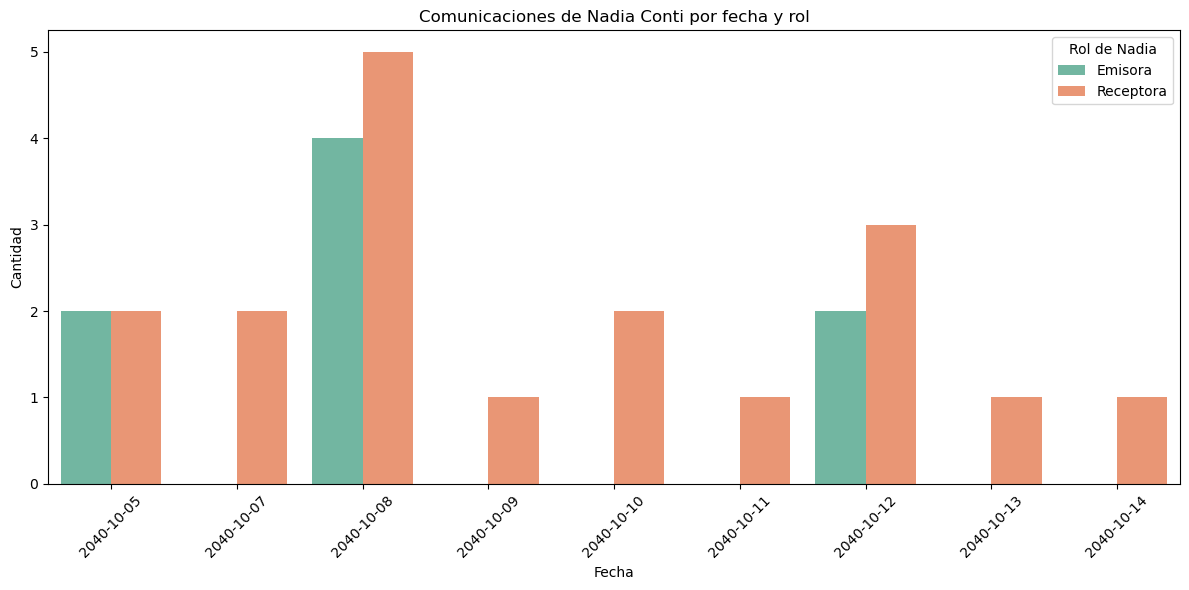

In [19]:
archivo = r"C:\Users\glova\OneDrive\Documentos\Visualización\Notebooks\relaciones_entidades.xlsx"
df = pd.read_excel(archivo)

# Asegurar que timestamp sea datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Filtrar comunicaciones donde Nadia esté involucrada
df_nadia = df[(df['source'] == 'Nadia Conti') | (df['target'] == 'Nadia Conti')]
df_nadia = df_nadia[df_nadia['sub_type'] == 'Communication'].copy()

# Extraer fecha
df_nadia['fecha'] = df_nadia['timestamp'].dt.date

# Determinar el rol de Nadia en cada comunicación
df_nadia['rol'] = df_nadia.apply(
    lambda row: 'Emisora' if row['source'] == 'Nadia Conti' else 'Receptora', axis=1
)

# Agrupar por fecha y rol
conteo = df_nadia.groupby(['fecha', 'rol']).size().reset_index(name='cantidad')

# Graficar
plt.figure(figsize=(12, 6))
sns.barplot(data=conteo, x='fecha', y='cantidad', hue='rol', palette='Set2')
plt.title("Comunicaciones de Nadia Conti por fecha y rol")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.xticks(rotation=45)
plt.legend(title="Rol de Nadia")
plt.tight_layout()
plt.show()


C:\Users\glova\AppData\Local\Temp\ipykernel_6320\298710925.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


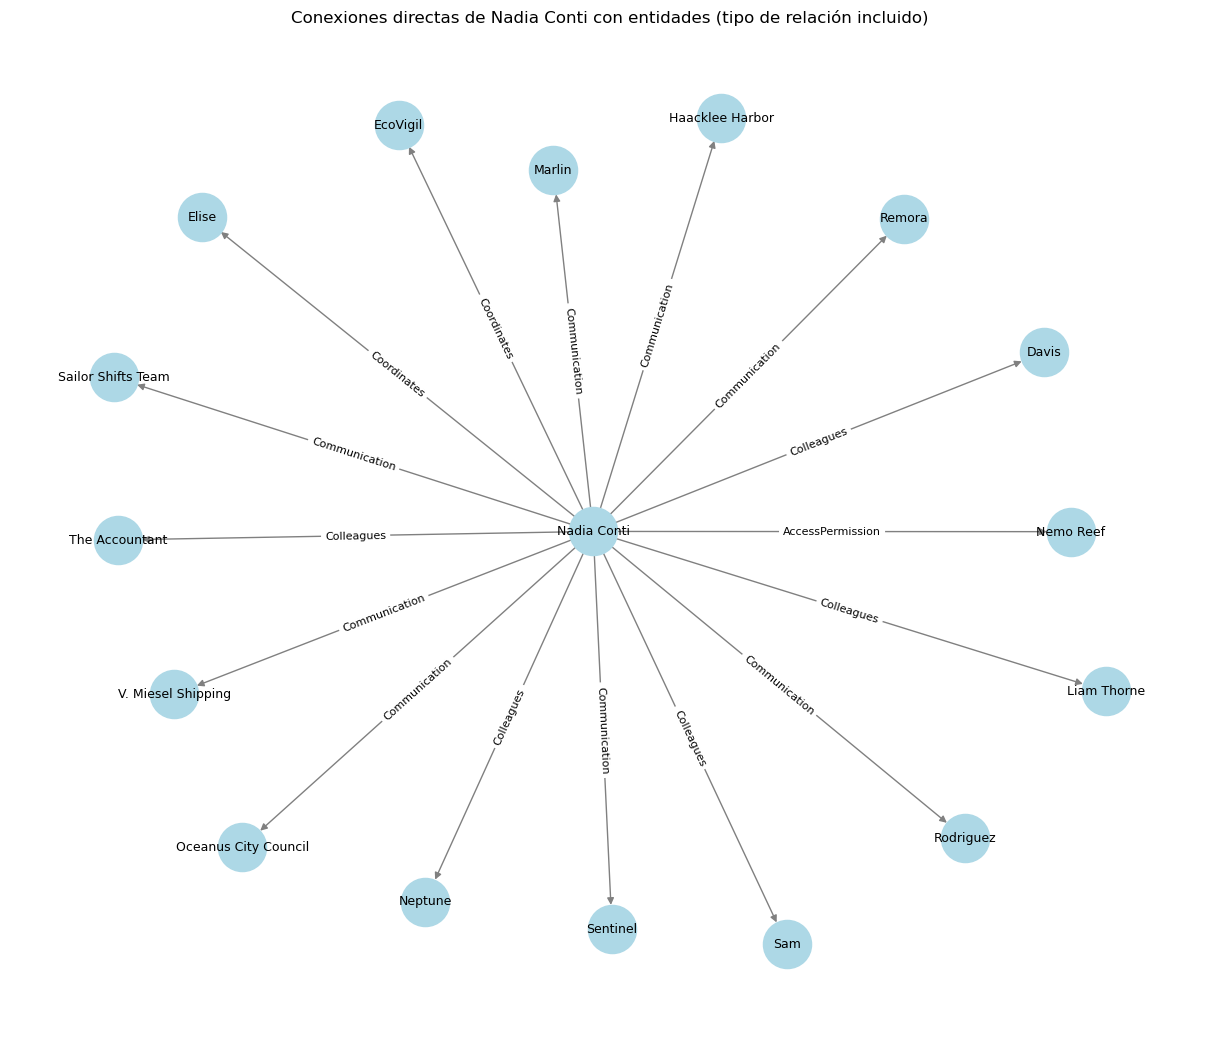

In [7]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph

# --- Cargar el grafo desde JSON ---
ruta_grafo = r"C:\Users\glova\Downloads\MC3_release_viz\MC3_release\MC3_graph_corregido.json"

with open(ruta_grafo, "r", encoding="utf-8") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data, directed=True)

# --- Crear grafo de conexiones directas con Nadia Conti ---
G_direct_nadia = nx.DiGraph()
nadia_node_id = None

# Buscar el ID de Nadia Conti
for node_id, attrs in G.nodes(data=True):
    if attrs.get("name") == "Nadia Conti":
        nadia_node_id = node_id
        break

# Agregar conexiones directas de Nadia
if nadia_node_id:
    for node_id, attrs in G.nodes(data=True):
        if attrs.get("type") in ["Relationship", "Event"]:
            vecinos = list(G.successors(node_id)) + list(G.predecessors(node_id))
            entidades = [n for n in vecinos if G.nodes[n].get("type") == "Entity"]
            if nadia_node_id in entidades:
                for entidad in entidades:
                    if entidad != nadia_node_id:
                        # Buscar tipo de relación
                        tipo = f"{attrs.get('sub_type', '')}".strip()
                        G_direct_nadia.add_node(entidad, label=G.nodes[entidad].get("name", ""))
                        G_direct_nadia.add_node(nadia_node_id, label="Nadia Conti")
                        G_direct_nadia.add_edge(nadia_node_id, entidad, label=tipo)

# --- Dibujar el grafo ---
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_direct_nadia, seed=42)
labels = {n: G.nodes[n].get("name", "") for n in G_direct_nadia.nodes}
edge_labels = nx.get_edge_attributes(G_direct_nadia, "label")

nx.draw(G_direct_nadia, pos, with_labels=False, node_color="lightblue", node_size=1200, edge_color="gray", arrows=True)
nx.draw_networkx_labels(G_direct_nadia, pos, labels=labels, font_size=9)
nx.draw_networkx_edge_labels(G_direct_nadia, pos, edge_labels=edge_labels, font_size=8)

plt.title("Conexiones directas de Nadia Conti con entidades (tipo de relación incluido)")
plt.axis("off")
plt.tight_layout()
plt.show()


C:\Users\glova\AppData\Local\Temp\ipykernel_6320\393631442.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


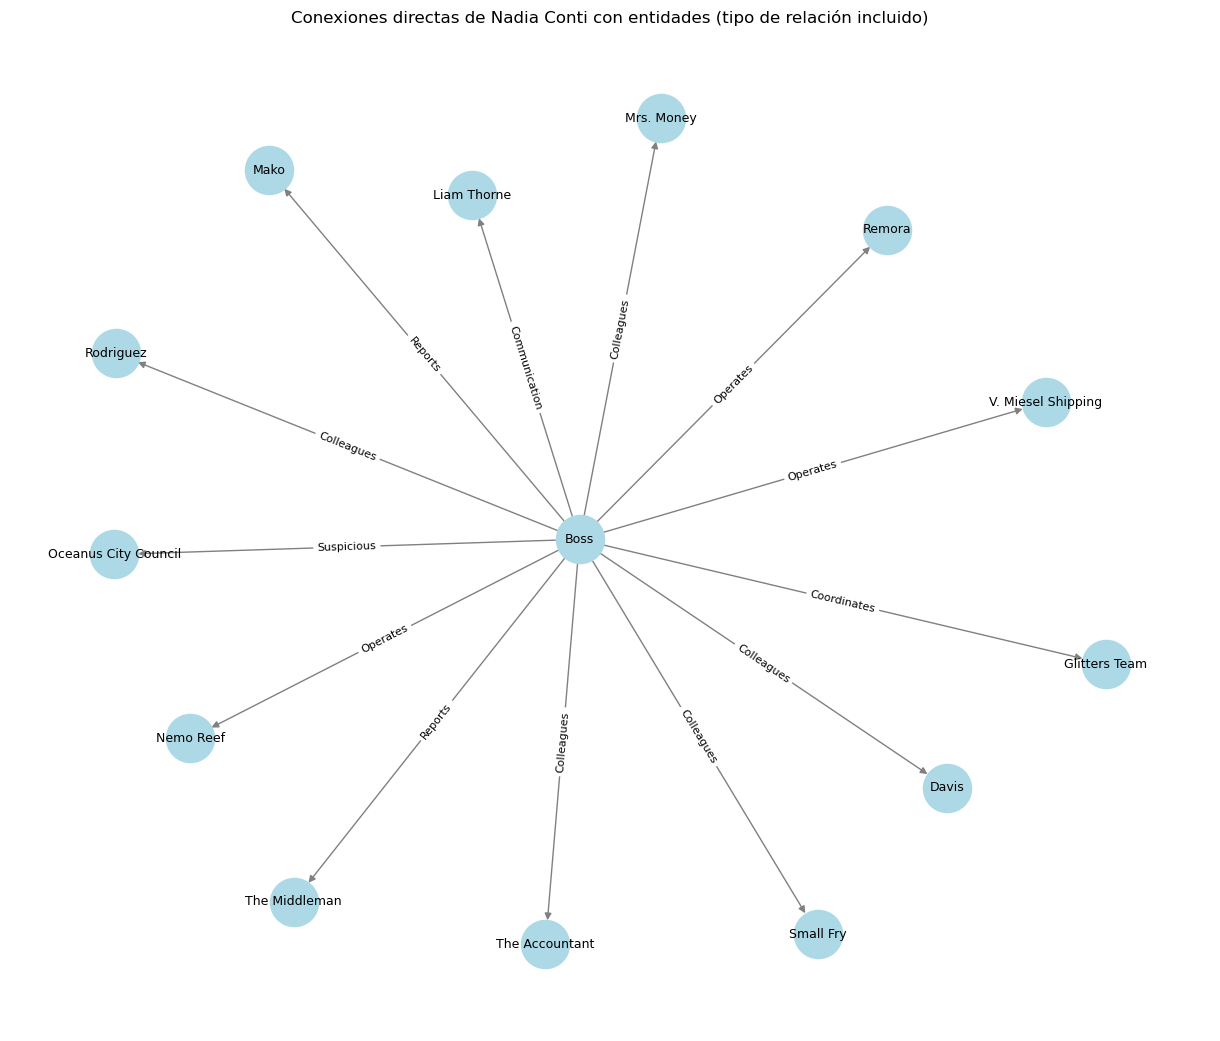

In [9]:
with open(ruta_grafo, "r", encoding="utf-8") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data, directed=True)

# --- Crear grafo de conexiones directas con Nadia Conti ---
G_direct_nadia = nx.DiGraph()
nadia_node_id = None

# Buscar el ID de Nadia Conti
for node_id, attrs in G.nodes(data=True):
    if attrs.get("name") == "Boss":
        nadia_node_id = node_id
        break

# Agregar conexiones directas de Nadia
if nadia_node_id:
    for node_id, attrs in G.nodes(data=True):
        if attrs.get("type") in ["Relationship", "Event"]:
            vecinos = list(G.successors(node_id)) + list(G.predecessors(node_id))
            entidades = [n for n in vecinos if G.nodes[n].get("type") == "Entity"]
            if nadia_node_id in entidades:
                for entidad in entidades:
                    if entidad != nadia_node_id:
                        # Buscar tipo de relación
                        tipo = f"{attrs.get('sub_type', '')}".strip()
                        G_direct_nadia.add_node(entidad, label=G.nodes[entidad].get("name", ""))
                        G_direct_nadia.add_node(nadia_node_id, label="Nadia Conti")
                        G_direct_nadia.add_edge(nadia_node_id, entidad, label=tipo)

# --- Dibujar el grafo ---
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_direct_nadia, seed=42)
labels = {n: G.nodes[n].get("name", "") for n in G_direct_nadia.nodes}
edge_labels = nx.get_edge_attributes(G_direct_nadia, "label")

nx.draw(G_direct_nadia, pos, with_labels=False, node_color="lightblue", node_size=1200, edge_color="gray", arrows=True)
nx.draw_networkx_labels(G_direct_nadia, pos, labels=labels, font_size=9)
nx.draw_networkx_edge_labels(G_direct_nadia, pos, edge_labels=edge_labels, font_size=8)

plt.title("Conexiones directas de Nadia Conti con entidades (tipo de relación incluido)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [11]:
import json
import networkx as nx
import pandas as pd
from collections import Counter
from networkx.readwrite import json_graph

# --- Cargar el grafo desde JSON ---
ruta_grafo = r"C:\Users\glova\Downloads\MC3_release_viz\MC3_release\MC3_graph_corregido.json"

with open(ruta_grafo, "r", encoding="utf-8") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data, directed=True)

# --- Identificar IDs de Nadia y Boss ---
nadia_node_id = None
boss_node_id = None
for node_id, attrs in G.nodes(data=True):
    if attrs.get("name") == "Nadia Conti":
        nadia_node_id = node_id
    elif attrs.get("name") == "Boss":
        boss_node_id = node_id

# --- Función para contar interacciones ---
def contar_interacciones(G, persona_id):
    conteo = Counter()
    for node_id, attrs in G.nodes(data=True):
        if attrs.get("type") in ["Relationship", "Event"]:
            vecinos = list(G.successors(node_id)) + list(G.predecessors(node_id))
            entidades = [n for n in vecinos if G.nodes[n].get("type") == "Entity"]
            if persona_id in entidades:
                for entidad in entidades:
                    if entidad != persona_id:
                        nombre = G.nodes[entidad].get("name", "")
                        conteo[nombre] += 1
    return conteo

# --- Contar interacciones para ambos ---
interacciones_nadia = contar_interacciones(G, nadia_node_id)
interacciones_boss = contar_interacciones(G, boss_node_id)

# --- Combinar en DataFrame ---
todos_nombres = sorted(set(interacciones_nadia.keys()).union(interacciones_boss.keys()))
datos = {
    "Entidad": todos_nombres,
    "Interacciones con Nadia Conti": [interacciones_nadia.get(n, 0) for n in todos_nombres],
    "Interacciones con Boss": [interacciones_boss.get(n, 0) for n in todos_nombres],
}
df = pd.DataFrame(datos)
df["Coincide con ambos"] = (df["Interacciones con Nadia Conti"] > 0) & (df["Interacciones con Boss"] > 0)

# --- Mostrar resultado ---
df.sort_values(by=["Coincide con ambos", "Entidad"], ascending=[False, True])


,Entidad,Interacciones con Nadia Conti,Interacciones con Boss,Coincide con ambos
0,Davis,8,2,True
5,Liam Thorne,5,1,True
9,Nemo Reef,1,2,True
11,Oceanus City Council,2,1,True
12,Remora,1,1,True
13,Rodriguez,1,4,True
18,The Accountant,1,3,True
20,V. Miesel Shipping,2,3,True
1,EcoVigil,1,0,False
2,Elise,5,0,False


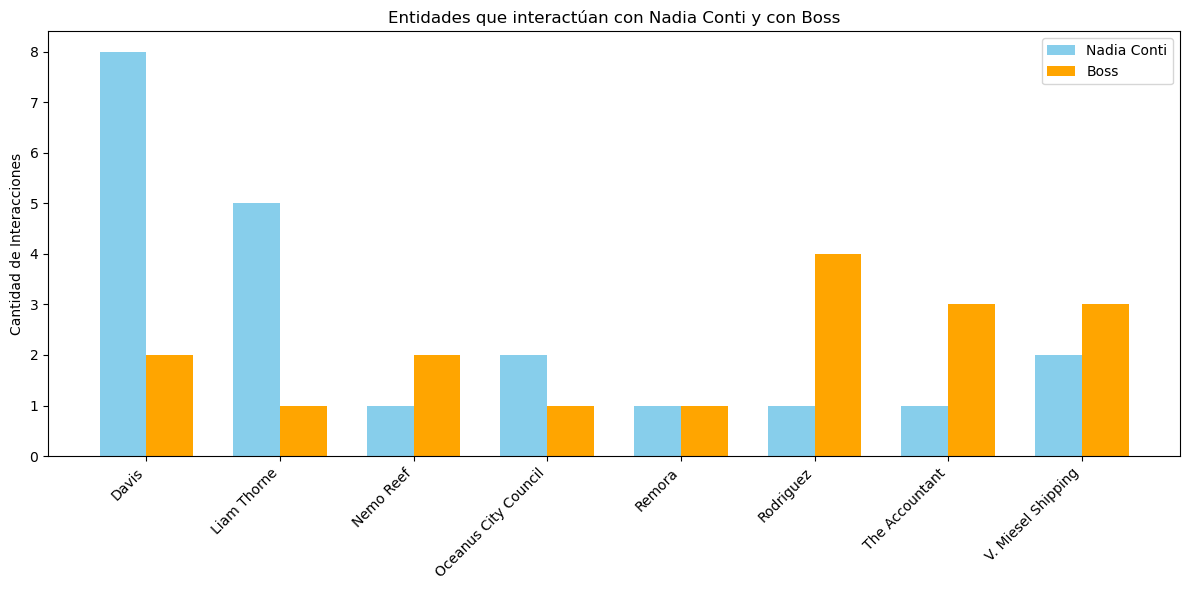

In [15]:
with open(ruta_grafo, "r", encoding="utf-8") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data, directed=True)

# --- Buscar los nodos de Nadia y Boss ---
nadia_node_id = None
boss_node_id = None
for node_id, attrs in G.nodes(data=True):
    if attrs.get("name") == "Nadia Conti":
        nadia_node_id = node_id
    elif attrs.get("name") == "Boss":
        boss_node_id = node_id

# --- Función para contar interacciones directas ---
def contar_interacciones(G, persona_id):
    conteo = Counter()
    for node_id, attrs in G.nodes(data=True):
        if attrs.get("type") in ["Relationship", "Event"]:
            vecinos = list(G.successors(node_id)) + list(G.predecessors(node_id))
            entidades = [n for n in vecinos if G.nodes[n].get("type") == "Entity"]
            if persona_id in entidades:
                for entidad in entidades:
                    if entidad != persona_id:
                        nombre = G.nodes[entidad].get("name", "")
                        conteo[nombre] += 1
    return conteo

# --- Obtener conteo de interacciones ---
interacciones_nadia = contar_interacciones(G, nadia_node_id)
interacciones_boss = contar_interacciones(G, boss_node_id)

# --- Construir DataFrame con coincidencias ---
todos_nombres = sorted(set(interacciones_nadia.keys()).union(interacciones_boss.keys()))
df = pd.DataFrame({
    "Entidad": todos_nombres,
    "Interacciones con Nadia Conti": [interacciones_nadia.get(n, 0) for n in todos_nombres],
    "Interacciones con Boss": [interacciones_boss.get(n, 0) for n in todos_nombres],
})
df["Coincide con ambos"] = (df["Interacciones con Nadia Conti"] > 0) & (df["Interacciones con Boss"] > 0)

# --- Filtrar solo coincidencias ---
df_comunes = df[df["Coincide con ambos"] == True]

# --- Gráfico de barras comparativo ---
plt.figure(figsize=(12, 6))
x = df_comunes["Entidad"]
width = 0.35
x_indices = range(len(x))

plt.bar(x_indices, df_comunes["Interacciones con Nadia Conti"], width=width, label="Nadia Conti", color="skyblue")
plt.bar([i + width for i in x_indices], df_comunes["Interacciones con Boss"], width=width, label="Boss", color="orange")

plt.xticks([i + width / 2 for i in x_indices], x, rotation=45, ha='right')
plt.ylabel("Cantidad de Interacciones")
plt.title("Entidades que interactúan con Nadia Conti y con Boss")
plt.legend()
plt.tight_layout()
plt.show()


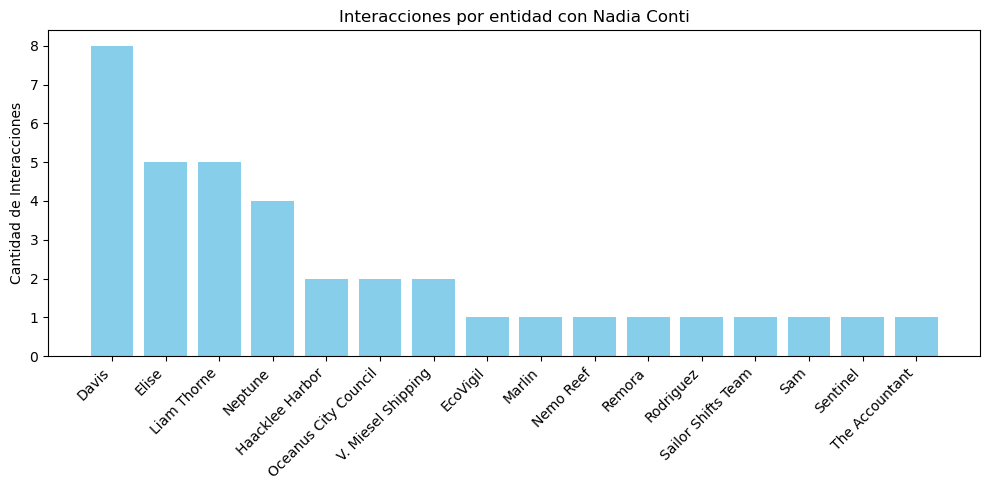

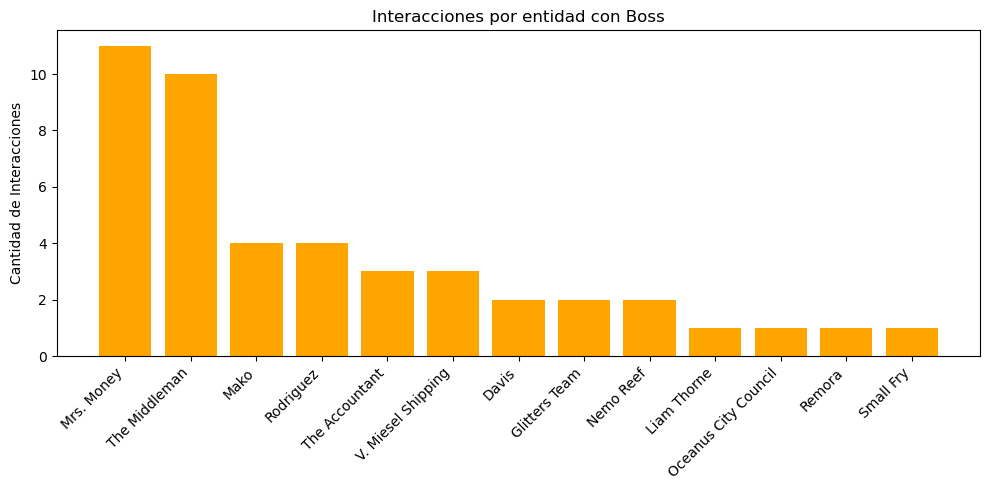

In [16]:
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from networkx.readwrite import json_graph

# --- Cargar grafo ---
ruta_grafo = r"C:\Users\glova\Downloads\MC3_release_viz\MC3_release\MC3_graph_corregido.json"

with open(ruta_grafo, "r", encoding="utf-8") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data, directed=True)

# --- Encontrar ID de Nadia y Boss ---
nadia_node_id = None
boss_node_id = None
for node_id, attrs in G.nodes(data=True):
    if attrs.get("name") == "Nadia Conti":
        nadia_node_id = node_id
    elif attrs.get("name") == "Boss":
        boss_node_id = node_id

# --- Función para contar interacciones directas ---
def contar_interacciones(G, persona_id):
    conteo = Counter()
    for node_id, attrs in G.nodes(data=True):
        if attrs.get("type") in ["Relationship", "Event"]:
            vecinos = list(G.successors(node_id)) + list(G.predecessors(node_id))
            entidades = [n for n in vecinos if G.nodes[n].get("type") == "Entity"]
            if persona_id in entidades:
                for entidad in entidades:
                    if entidad != persona_id:
                        nombre = G.nodes[entidad].get("name", "")
                        conteo[nombre] += 1
    return conteo

# --- Contar interacciones ---
interacciones_nadia = contar_interacciones(G, nadia_node_id)
interacciones_boss = contar_interacciones(G, boss_node_id)

# --- Crear DataFrame ---
todos_nombres = sorted(set(interacciones_nadia.keys()).union(interacciones_boss.keys()))
df = pd.DataFrame({
    "Entidad": todos_nombres,
    "Interacciones con Nadia Conti": [interacciones_nadia.get(n, 0) for n in todos_nombres],
    "Interacciones con Boss": [interacciones_boss.get(n, 0) for n in todos_nombres],
})

# --- Gráfico 1: Interacciones con Nadia ---
plt.figure(figsize=(10, 5))
df_nadia = df[df["Interacciones con Nadia Conti"] > 0].sort_values(by="Interacciones con Nadia Conti", ascending=False)
plt.bar(df_nadia["Entidad"], df_nadia["Interacciones con Nadia Conti"], color="skyblue")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Cantidad de Interacciones")
plt.title("Interacciones por entidad con Nadia Conti")
plt.tight_layout()
plt.show()

# --- Gráfico 2: Interacciones con Boss ---
plt.figure(figsize=(10, 5))
df_boss = df[df["Interacciones con Boss"] > 0].sort_values(by="Interacciones con Boss", ascending=False)
plt.bar(df_boss["Entidad"], df_boss["Interacciones con Boss"], color="orange")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Cantidad de Interacciones")
plt.title("Interacciones por entidad con Boss")
plt.tight_layout()
plt.show()


C:\Users\glova\AppData\Local\Temp\ipykernel_6320\3772549827.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["periodo_12h"] = df["timestamp"].dt.floor("12H")  # Agrupa cada 12 horas
C:\Users\glova\AppData\Local\Temp\ipykernel_6320\3772549827.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["periodo_12h"] = df["timestamp"].dt.floor("12H")  # Agrupa cada 12 horas


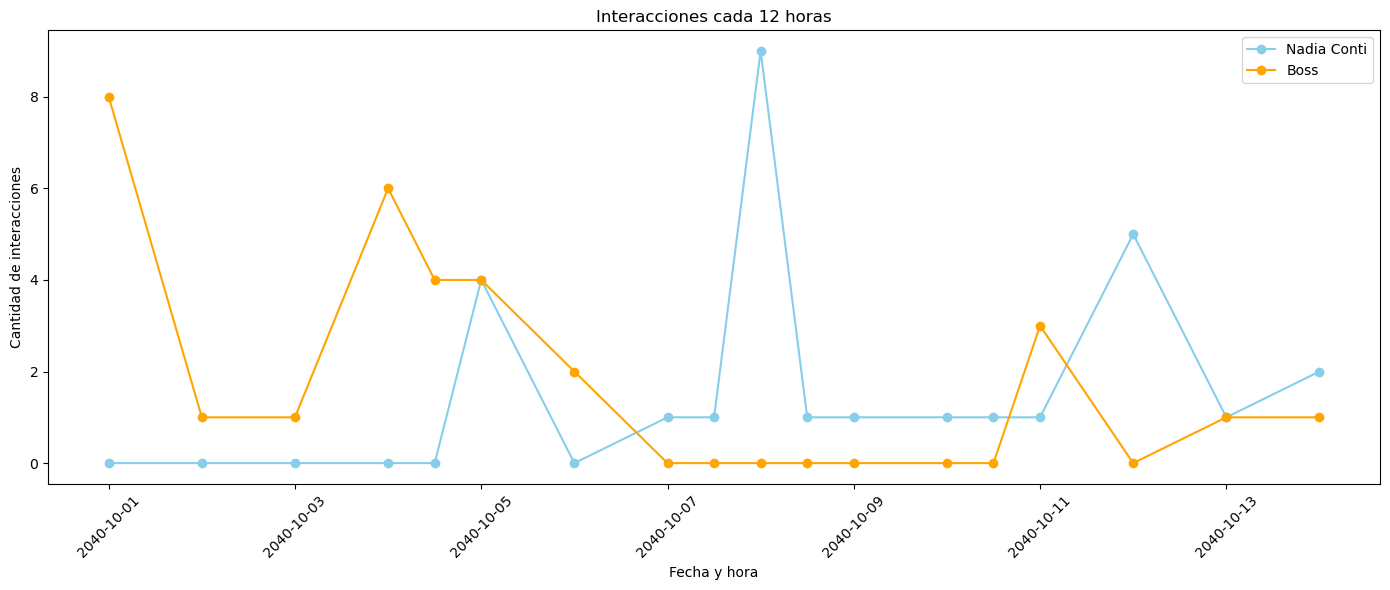

In [19]:
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from networkx.readwrite import json_graph

# --- Cargar grafo desde archivo ---
ruta_grafo = r"C:\Users\glova\Downloads\MC3_release_viz\MC3_release\MC3_graph_corregido.json"

with open(ruta_grafo, "r", encoding="utf-8") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data, directed=True)

# --- Identificar IDs de Nadia y Boss ---
nadia_node_id = None
boss_node_id = None
for node_id, attrs in G.nodes(data=True):
    if attrs.get("name") == "Nadia Conti":
        nadia_node_id = node_id
    elif attrs.get("name") == "Boss":
        boss_node_id = node_id

# --- Función para obtener interacciones por bloque de 12 horas ---
def obtener_interacciones_temporales(G, persona_id, nombre):
    interacciones = []
    for node_id, attrs in G.nodes(data=True):
        if attrs.get("type") in ["Relationship", "Event"] and "timestamp" in attrs:
            vecinos = list(G.successors(node_id)) + list(G.predecessors(node_id))
            entidades = [n for n in vecinos if G.nodes[n].get("type") == "Entity"]
            if persona_id in entidades:
                interacciones.append(attrs["timestamp"])
    df = pd.DataFrame({"timestamp": pd.to_datetime(interacciones)})
    df["periodo_12h"] = df["timestamp"].dt.floor("12H")  # Agrupa cada 12 horas
    serie = df.groupby("periodo_12h").size().rename(nombre)
    return serie

# --- Obtener series de interacciones para Nadia y Boss ---
serie_nadia = obtener_interacciones_temporales(G, nadia_node_id, "Nadia Conti")
serie_boss = obtener_interacciones_temporales(G, boss_node_id, "Boss")

# --- Unir las dos series y rellenar NaN con 0 ---
df_series = pd.concat([serie_nadia, serie_boss], axis=1).fillna(0)

# --- Graficar ---
plt.figure(figsize=(14, 6))
plt.plot(df_series.index, df_series["Nadia Conti"], label="Nadia Conti", marker='o', color='skyblue')
plt.plot(df_series.index, df_series["Boss"], label="Boss", marker='o', color='orange')
plt.title("Interacciones cada 12 horas")
plt.xlabel("Fecha y hora")
plt.ylabel("Cantidad de interacciones")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\glova\AppData\Local\Temp\ipykernel_6320\4195811141.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["periodo_12h"] = df["timestamp"].dt.floor("12H")
C:\Users\glova\AppData\Local\Temp\ipykernel_6320\4195811141.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["periodo_12h"] = df["timestamp"].dt.floor("12H")


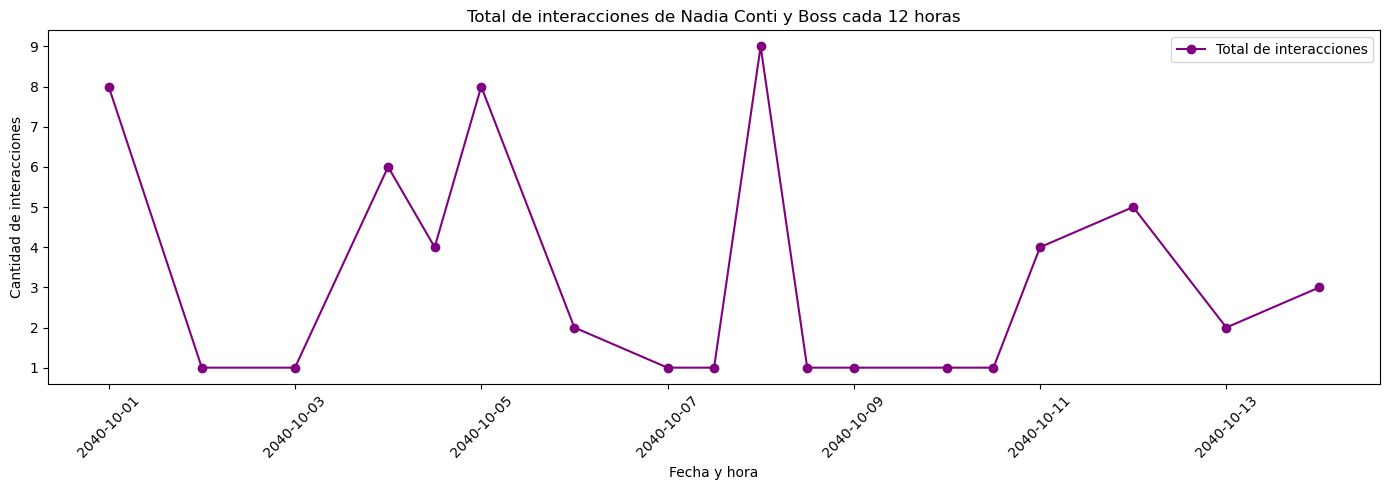

In [20]:
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph

# --- Cargar grafo desde archivo ---
ruta_grafo = r"C:\Users\glova\Downloads\MC3_release_viz\MC3_release\MC3_graph_corregido.json"

with open(ruta_grafo, "r", encoding="utf-8") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data, directed=True)

# --- Identificar IDs de Nadia y Boss ---
nadia_node_id = None
boss_node_id = None
for node_id, attrs in G.nodes(data=True):
    if attrs.get("name") == "Nadia Conti":
        nadia_node_id = node_id
    elif attrs.get("name") == "Boss":
        boss_node_id = node_id

# --- Función para obtener interacciones por bloque de 12 horas ---
def obtener_interacciones_temporales(G, persona_id, nombre):
    interacciones = []
    for node_id, attrs in G.nodes(data=True):
        if attrs.get("type") in ["Relationship", "Event"] and "timestamp" in attrs:
            vecinos = list(G.successors(node_id)) + list(G.predecessors(node_id))
            entidades = [n for n in vecinos if G.nodes[n].get("type") == "Entity"]
            if persona_id in entidades:
                interacciones.append(attrs["timestamp"])
    df = pd.DataFrame({"timestamp": pd.to_datetime(interacciones)})
    df["periodo_12h"] = df["timestamp"].dt.floor("12H")
    serie = df.groupby("periodo_12h").size().rename(nombre)
    return serie

# --- Obtener series ---
serie_nadia = obtener_interacciones_temporales(G, nadia_node_id, "Nadia Conti")
serie_boss = obtener_interacciones_temporales(G, boss_node_id, "Boss")

# --- Combinar y calcular total ---
df_series = pd.concat([serie_nadia, serie_boss], axis=1).fillna(0)
df_series["Total"] = df_series["Nadia Conti"] + df_series["Boss"]

# --- Gráfico de línea: total de interacciones ---
plt.figure(figsize=(14, 5))
plt.plot(df_series.index, df_series["Total"], label="Total de interacciones", marker='o', color='purple')
plt.title("Total de interacciones de Nadia Conti y Boss cada 12 horas")
plt.xlabel("Fecha y hora")
plt.ylabel("Cantidad de interacciones")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\glova\AppData\Local\Temp\ipykernel_6320\696302231.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["periodo_1h"] = df["timestamp"].dt.floor("H")  # Agrupar por hora
C:\Users\glova\AppData\Local\Temp\ipykernel_6320\696302231.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["periodo_1h"] = df["timestamp"].dt.floor("H")  # Agrupar por hora


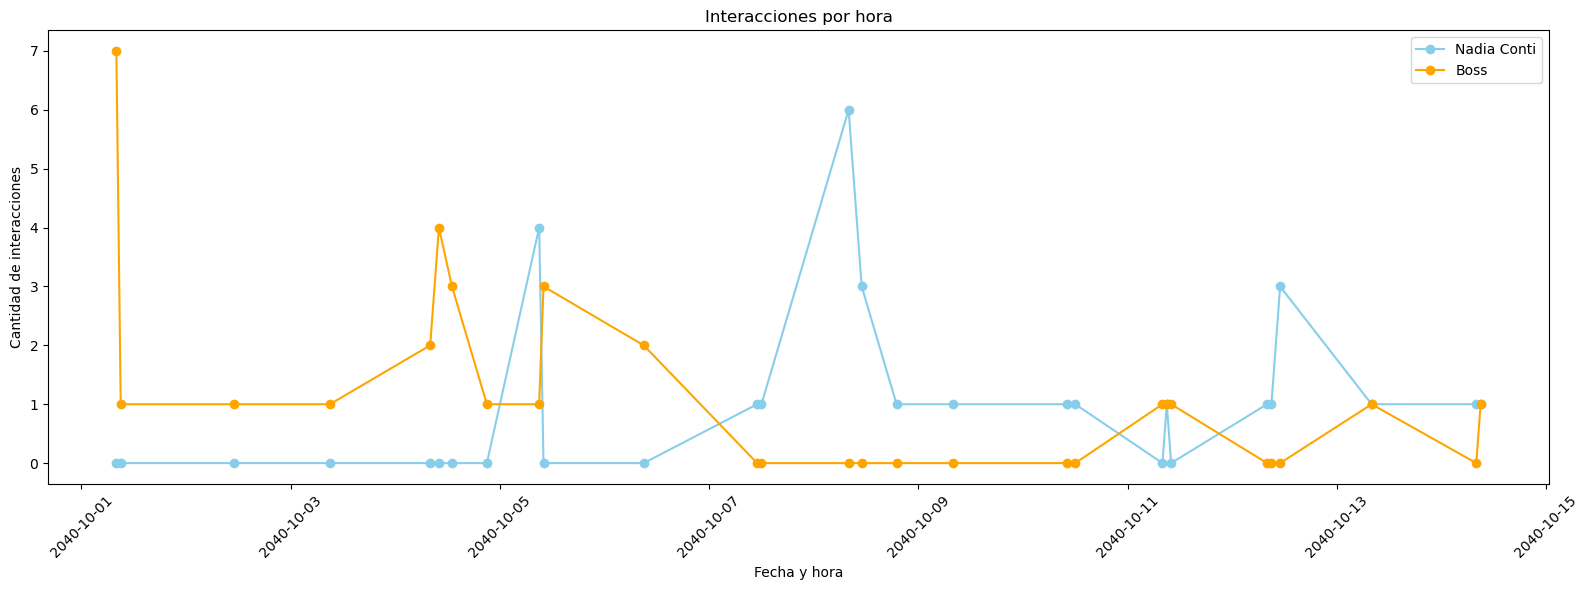

In [22]:
# --- Función para obtener interacciones por hora ---
def obtener_interacciones_temporales(G, persona_id, nombre):
    interacciones = []
    for node_id, attrs in G.nodes(data=True):
        if attrs.get("type") in ["Relationship", "Event"] and "timestamp" in attrs:
            vecinos = list(G.successors(node_id)) + list(G.predecessors(node_id))
            entidades = [n for n in vecinos if G.nodes[n].get("type") == "Entity"]
            if persona_id in entidades:
                interacciones.append(attrs["timestamp"])
    df = pd.DataFrame({"timestamp": pd.to_datetime(interacciones)})
    df["periodo_1h"] = df["timestamp"].dt.floor("H")  # Agrupar por hora
    serie = df.groupby("periodo_1h").size().rename(nombre)
    return serie

# Obtener series
serie_nadia = obtener_interacciones_temporales(G, nadia_node_id, "Nadia Conti")
serie_boss = obtener_interacciones_temporales(G, boss_node_id, "Boss")

# Combinar series
df_series = pd.concat([serie_nadia, serie_boss], axis=1).fillna(0)

# --- Graficar ---
plt.figure(figsize=(16, 6))
plt.plot(df_series.index, df_series["Nadia Conti"], label="Nadia Conti", marker='o', color='skyblue')
plt.plot(df_series.index, df_series["Boss"], label="Boss", marker='o', color='orange')
plt.title("Interacciones por hora")
plt.xlabel("Fecha y hora")
plt.ylabel("Cantidad de interacciones")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
import json
import networkx as nx
import pandas as pd
from networkx.readwrite import json_graph

# --- Cargar grafo ---
ruta_grafo = r"C:\Users\glova\Downloads\MC3_release_viz\MC3_release\MC3_graph_corregido.json"
with open(ruta_grafo, "r", encoding="utf-8") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data, directed=True)

# --- Identificar IDs de Nadia y Boss ---
nadia_node_id = None
boss_node_id = None
for node_id, attrs in G.nodes(data=True):
    if attrs.get("name") == "Nadia Conti":
        nadia_node_id = node_id
    elif attrs.get("name") == "Boss":
        boss_node_id = node_id

# --- Función para obtener interacciones con fecha y entidad ---
def obtener_interacciones_con_fechas(G, persona_id):
    registros = []
    for node_id, attrs in G.nodes(data=True):
        if attrs.get("type") in ["Relationship", "Event"] and "timestamp" in attrs:
            timestamp = pd.to_datetime(attrs["timestamp"])
            vecinos = list(G.successors(node_id)) + list(G.predecessors(node_id))
            entidades = [n for n in vecinos if G.nodes[n].get("type") == "Entity"]
            if persona_id in entidades:
                for entidad in entidades:
                    if entidad != persona_id:
                        registros.append({
                            "fecha": timestamp.date(),
                            "entidad": G.nodes[entidad].get("name", "")
                        })
    return pd.DataFrame(registros)

# --- Obtener DataFrames para cada persona ---
df_nadia = obtener_interacciones_con_fechas(G, nadia_node_id)
df_boss = obtener_interacciones_con_fechas(G, boss_node_id)

# --- Buscar coincidencias de fecha + entidad ---
df_coinciden = pd.merge(df_nadia, df_boss, on=["fecha", "entidad"], how="inner").drop_duplicates()

# --- Mostrar resultado ---
print("Entidades con las que Nadia y Boss interactuaron en la misma fecha:")
print(df_coinciden)


Entidades con las que Nadia y Boss interactuaron en la misma fecha:
        fecha      entidad
0  2040-10-11  Liam Thorne
1  2040-10-14        Davis


In [25]:
import json
import networkx as nx
import pandas as pd
from networkx.readwrite import json_graph

# --- Cargar grafo ---
ruta_grafo = r"C:\Users\glova\Downloads\MC3_release_viz\MC3_release\MC3_graph_corregido.json"
with open(ruta_grafo, "r", encoding="utf-8") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data, directed=True)

# --- Identificar nodos de Nadia y Boss ---
nadia_node_id = None
boss_node_id = None
for node_id, attrs in G.nodes(data=True):
    if attrs.get("name") == "Nadia Conti":
        nadia_node_id = node_id
    elif attrs.get("name") == "Boss":
        boss_node_id = node_id

# --- Función para obtener interacciones por fecha y entidad ---
def obtener_interacciones_con_fechas(G, persona_id):
    registros = []
    for node_id, attrs in G.nodes(data=True):
        if attrs.get("type") in ["Relationship", "Event"] and "timestamp" in attrs:
            try:
                fecha = pd.to_datetime(attrs["timestamp"]).date()
            except:
                continue
            vecinos = list(G.successors(node_id)) + list(G.predecessors(node_id))
            entidades = [n for n in vecinos if G.nodes[n].get("type") == "Entity"]
            for entidad in entidades:
                if entidad != persona_id and persona_id in entidades:
                    registros.append({
                        "fecha": fecha,
                        "entidad": G.nodes[entidad].get("name", "")
                    })
    return pd.DataFrame(registros)

# --- DataFrames con interacciones por fecha y entidad ---
df_nadia = obtener_interacciones_con_fechas(G, nadia_node_id)
df_boss = obtener_interacciones_con_fechas(G, boss_node_id)

# --- Coincidencias exactas de fecha + entidad
df_comparacion = pd.merge(df_nadia, df_boss, on=["fecha", "entidad"], how="inner").drop_duplicates()

# --- Extraer mensajes de tipo Communication en esas coincidencias ---
coincidencias_fecha_entidad = set(zip(df_comparacion["fecha"], df_comparacion["entidad"]))

mensajes_comunes = []
for node_id, attrs in G.nodes(data=True):
    if attrs.get("type") == "Event" and attrs.get("sub_type") == "Communication":
        timestamp = attrs.get("timestamp")
        if not timestamp or "content" not in attrs:
            continue
        fecha = pd.to_datetime(timestamp).date()
        vecinos = list(G.successors(node_id)) + list(G.predecessors(node_id))
        entidades = [n for n in vecinos if G.nodes[n].get("type") == "Entity"]
        nombres = [G.nodes[n].get("name", "") for n in entidades]

        for nombre in nombres:
            if (fecha, nombre) in coincidencias_fecha_entidad:
                mensajes_comunes.append({
                    "fecha": fecha,
                    "entidad": nombre,
                    "mensaje": attrs["content"]
                })

# --- Tabla final de mensajes ---
df_mensajes = pd.DataFrame(mensajes_comunes).drop_duplicates()

# Mostrar resultado
df_mensajes


,fecha,entidad,mensaje
0,2040-10-11,Liam Thorne,"The Middleman, Mrs. Money here. Any intel on V..."
1,2040-10-11,Liam Thorne,"Elise, Liam here. Conservation vessels found n..."
2,2040-10-11,Liam Thorne,"Liam, this is EcoVigil. Per Council approval, ..."
3,2040-10-11,Liam Thorne,"Boss, Liam here. We have a problem. EcoVigil g..."
4,2040-10-11,Liam Thorne,"Liam, Oceanus City Council here. We need you t..."
5,2040-10-11,Liam Thorne,"EcoVigil, Liam Thorne here. Your ROV deploymen..."
6,2040-10-11,Liam Thorne,"Liam, EcoVigil here. Understood about the nort..."
7,2040-10-11,Liam Thorne,"Nadia, Liam here. EcoVigil is questioning the ..."
8,2040-10-14,Davis,"Davis, Mako here. Operation complete at Nemo R..."
9,2040-10-14,Davis,Davis to Mako. Well done on Nemo Reef operatio...


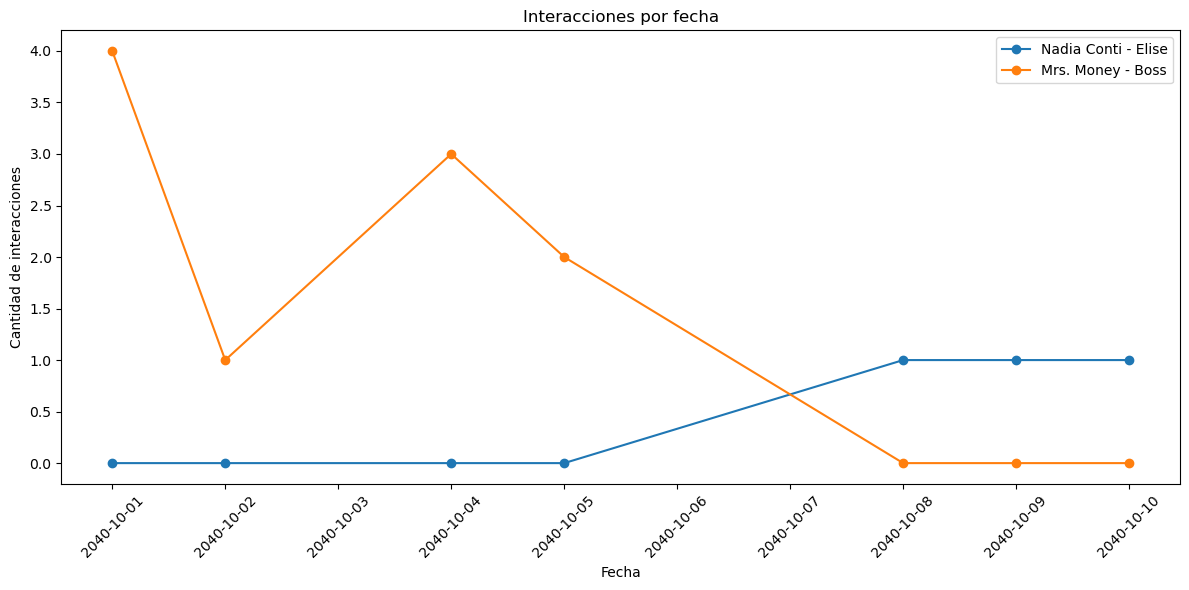

In [26]:
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph

# --- Cargar grafo ---
ruta_grafo = r"C:\Users\glova\Downloads\MC3_release_viz\MC3_release\MC3_graph_corregido.json"
with open(ruta_grafo, "r", encoding="utf-8") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data, directed=True)

# --- Función para contar interacciones entre dos personas por fecha ---
def interacciones_entre(G, nombre_1, nombre_2):
    id_1 = id_2 = None
    for node_id, attrs in G.nodes(data=True):
        if attrs.get("name") == nombre_1:
            id_1 = node_id
        elif attrs.get("name") == nombre_2:
            id_2 = node_id

    registros = []
    for node_id, attrs in G.nodes(data=True):
        if attrs.get("type") in ["Relationship", "Event"] and "timestamp" in attrs:
            vecinos = list(G.successors(node_id)) + list(G.predecessors(node_id))
            if id_1 in vecinos and id_2 in vecinos:
                try:
                    fecha = pd.to_datetime(attrs["timestamp"]).date()
                    registros.append(fecha)
                except:
                    continue
    return pd.Series(registros).value_counts().sort_index()

# --- Obtener series de interacciones ---
serie_nadia_elise = interacciones_entre(G, "Nadia Conti", "Elise")
serie_mrs_boss = interacciones_entre(G, "Mrs. Money", "Boss")

# --- Unir en un solo DataFrame ---
df_dos_parejas = pd.DataFrame({
    "Nadia Conti - Elise": serie_nadia_elise,
    "Mrs. Money - Boss": serie_mrs_boss
}).fillna(0)

# --- Graficar ---
plt.figure(figsize=(12, 6))
plt.plot(df_dos_parejas.index, df_dos_parejas["Nadia Conti - Elise"], label="Nadia Conti - Elise", marker='o')
plt.plot(df_dos_parejas.index, df_dos_parejas["Mrs. Money - Boss"], label="Mrs. Money - Boss", marker='o')
plt.title("Interacciones por fecha")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de interacciones")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
